# Basic Data Manipulation



In [1]:
# Import Dependencies and Define Global Variables
import pandas_datareader.data as web
import pandas as pd
import numpy as np
# configure ldconf or environment variable
# export LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH
from talib import RSI, BBANDS, EMA
import matplotlib.pyplot as plt

start = '2009-08-14'
end = '2021-02-19'
symbol = ['INFO', 'AAPL', 'AMZN', 'SPY']
max_holding = 10000

In [ ]:
# Download Data

# set IEX_API_KEY= before using iex
# To suppress potential SSL error
# export CURL_CA_BUNDLE=""
sample0 = web.DataReader(name=symbol, data_source='iex', start=start, end=end)
# set QUANDL_API_KEY before using quandl
# caveat: didn't find US ETF from quandl
# price = web.DataReader(name=symbol, data_source='quandl', start=start, end=end)
%store sample0

## Portfolio Construction
After fetching historical prices, we can see the data contains open/high/low/close/volume for each symbol.

In [2]:
%store -r sample0
sample0.tail(1)

Attributes   open                            high                          \
Symbols      INFO    AAPL     AMZN     SPY   INFO    AAPL    AMZN     SPY   
date                                                                        
2021-02-19  93.03  130.24  3328.23  392.07  94.04  130.71  3333.5  392.38   

Attributes    low                         close                          \
Symbols      INFO   AAPL     AMZN     SPY  INFO    AAPL    AMZN     SPY   
date                                                                      
2021-02-19  92.91  128.8  3245.75  389.55  93.2  129.87  3249.9  390.03   

Attributes     volume                                     
Symbols          INFO        AAPL       AMZN         SPY  
date                                                      
2021-02-19  1839102.0  87668834.0  4305184.0  83240971.0

Let's drop NaN as INFO was listed later than others, and keep only close price.

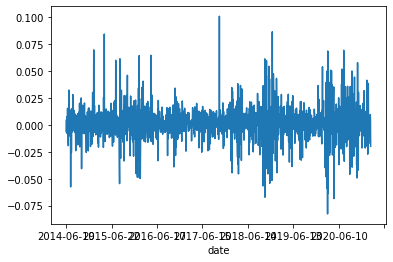

In [3]:
# To calculate sharpe ratio, we need daily returns, their std
sample0.dropna()
close = sample0['close']
# INFO was list at 2014, remove previous rows
close = close[close.index > '2014-06-18']
close = close.dropna()

# assume 25% weight for each symbol, and get portfolio holdings
portfolio = close*[0.25,0.25,0.25,0.25]*max_holding
# calculate value of portfolio
value = portfolio.sum(axis=1).rename('value')
# value.plot()
# calculate daily return of portfolio
daily_return = value.pct_change(1)
daily_return.plot()
# get mean of return
mean = daily_return.mean()
# get std of return
std = daily_return.std()
# sharpe ratio
sharpe = mean/std*(252**0.5)



Now let's get more risk analysis


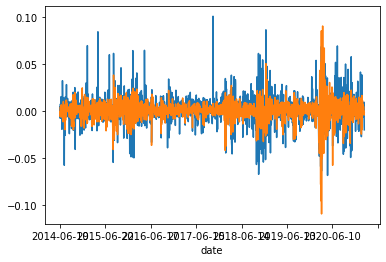

In [15]:
benchmark = close['SPY']
benchmarkR = benchmark.pct_change()

daily_return.plot()
benchmarkR.plot()

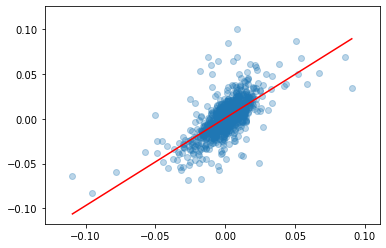

In [29]:
import statsmodels.api as sm
from statsmodels import regression

benchmarkR = sm.add_constant(benchmarkR)
model = regression.linear_model.OLS(daily_return[1:],benchmarkR[1:]).fit()
benchmarkR = benchmarkR['SPY']
# Alpha
alpha = model.params[0]
# Beta
beta = model.params[1]

X = np.linspace(benchmarkR.min(), benchmarkR.max(), 100)
Y = X * beta + alpha

plt.scatter(benchmarkR, daily_return, alpha = 0.3)
plt.plot(X, Y, 'r')